Copyright (c) 2017 Andrew Johnson, Dan Kotlyar, GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## `DetectorReader`

### Basic Operation
This notebook details how to utilize the [`serpentTools`](https://github.com/CORE-GATECH-GROUP/serpent-tools) package for reading detector files, `[input]_det[N].m` produced by SERPENT [1]. 
Detectors can be defined with many binning parameters, listed [on the SERPENT Wiki](http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#det_.28detector_definition.29). 
One could define a detector that has a spatial mesh, `dx/dy/dz/`, but also includes reaction and material bins, `dr, dm`. 
Detectors are stored on the reader object in the ``detectors`` dictionary as custom ``Detector`` objects. Here, all energy and spatial grid data are stored, including other binning information such as reaction, universe, and lattice bins. 

In [29]:
%matplotlib inline
import serpentTools

In [30]:
detFile = 'demo_det0.m'
det = serpentTools.read(detFile)

INFO    : serpentTools: Inferred reader for demo_det0.m: DetectorReader
INFO    : serpentTools: Preparing to read demo_det0.m
INFO    : serpentTools: Done


In [31]:
det.detectors

{'nodeFlx': <serpentTools.objects.containers.Detector at 0x19e3c4f6b70>,
 'spectrum': <serpentTools.objects.containers.Detector at 0x19e3c4f6ba8>,
 'xyFissionCapt': <serpentTools.objects.containers.Detector at 0x19e3c4f6470>}

These detectors were defined to a single fuel pin, divided into 16 axial segments by unique materials. A description of the detectors provided in the output:

|Name| Description|
|----|------------|
|`nodeFlx`|Flux-share in each axial universe|
|`spectrum`|1968 group flux in fuel pin|
|`xyFissionCapt`|One-group fission and capture rate for a 5x5 xy grid|

For each `Detector` object, the full tally matrix is stored in the `bins` array.

In [32]:
nodeFlx = det.detectors['nodeFlx']
print(nodeFlx.bins.shape)
nodeFlx.bins[:5,:]

(16, 12)


array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.34759000e-02,   4.53000000e-03],
       [  2.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   5.75300000e-02,   3.38000000e-03],
       [  3.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   8.47000000e-02,   2.95000000e-03],
       [  4.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.02034000e-01,   2.63000000e-03],
    

Here, only three columns are changing: 

* column 0: universe column
* column 10: tally column
* column 11: errors

*Note* For SERPENT-1, there would be an additional column 12 that contained the scores for each bin

In [33]:
nodeFlx.bins[:, 0]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.])

Once each detector is given this binned tally data, the `reshape` method is called to recast the tallies, errors, and, if applicable, the scores columns into individual, multidimensional arrays. For this case, since the only variable bin quantity is that of the universe, these will all be 1D arrays.

In [34]:
assert nodeFlx.tallies.shape == (16, )
assert nodeFlx.errors.shape == (16, )
nodeFlx.tallies

array([ 0.0234759 ,  0.05753   ,  0.0847    ,  0.102034  ,  0.110384  ,
        0.110174  ,  0.102934  ,  0.0928861 ,  0.0810541 ,  0.067961  ,
        0.0550446 ,  0.0422486 ,  0.0310226 ,  0.0211475 ,  0.0125272 ,
        0.00487726])

In [35]:
nodeFlx.errors

array([ 0.00453,  0.00338,  0.00295,  0.00263,  0.00231,  0.00222,
        0.00238,  0.00251,  0.00282,  0.00307,  0.00359,  0.00415,
        0.00511,  0.00687,  0.00809,  0.01002])

Bin information is retained through the `indexes` attribute. This is an OrderedDictionary, as the keys are placed according to their column position. These postions can be found in the SERPENT Manual, and are provided in the `DET_COLS` tuple

In [36]:
from serpentTools.objects.containers import DET_COLS
print(DET_COLS)

('value', 'energy', 'universe', 'cell', 'material', 'lattice', 'reaction', 'zmesh', 'ymesh', 'xmesh', 'tally', 'error', 'scores')


In [37]:
nodeFlx.indexes

OrderedDict([('universe',
              array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
                      12.,  13.,  14.,  15.,  16.]))])

Each item in the `indexes` ordered dictionary corresponds to the unique values of that bin in the original `bin` array.
Here, `universe` is the first item and contains an equal number of elements to the size of the first (and only) axis in the nodeFlx tally matrix

In [38]:
assert nodeFlx.indexes['universe'].size == nodeFlx.tallies.size

### Plotting Routines

Each `Detector` object is capable of simple 1D and 2D plotting routines. 
The simplest 1D plot method is simply `plot`, however a wide range of plot options are present.

|Option|Description|
|-|-|
|`what`|What data to plot|
|`ax`|Preprepared figure on which to add this plot|
|`xdim`|Quantity from `indexes` to use as x-axis|
|`sigma`|Confidence interval to place on errors|
|`steps`|Draw tally values as constant inside bin|


The plot routine also accepts various options, which can be found in the [matplotlib.pyplot.plot documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)

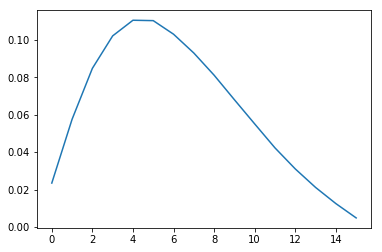

In [39]:
nodeFlx.plot();

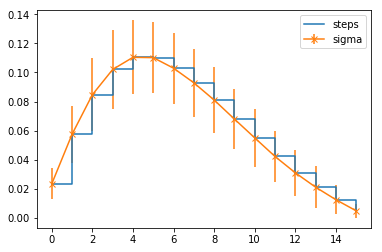

In [40]:
ax = nodeFlx.plot(steps=True, label='steps')
nodeFlx.plot(sigma=100, ax=ax, marker='x', label='sigma')
ax.legend();

Passing `what='errors'` to the plot method plots the associated relative errors, rather than the tally data on the y-axis. 
Similarly, passing a key from `indexes` sets the x-axis to be that specific index.

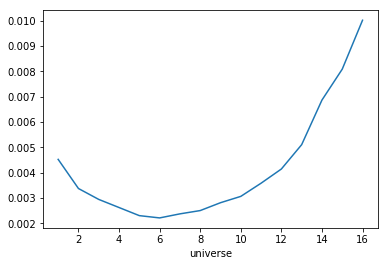

In [41]:
nodeFlx.plot(xdim='universe', what='errors');

For detectors that include some grid matrices, such as spatial or energy meshes `DET<name>E`, these arrays are stored in the `grids` dictionary

In [42]:
spectrum = det.detectors['spectrum']
print(spectrum.grids['E'][:5, :])

[[  1.00001000e-11   3.00000000e-09   1.50500000e-09]
 [  3.00000000e-09   5.00000000e-09   4.00000000e-09]
 [  5.00000000e-09   6.90000000e-09   5.95000000e-09]
 [  6.90000000e-09   1.00000000e-08   8.45000000e-09]
 [  1.00000000e-08   1.50000000e-08   1.25000000e-08]]


The `spectrum` plot method is designed to prepare plots of energy spectra. Supported arguments for the `spectrumPlot` method include

|Option|Default|Description|
|-|-|-|
|`normalize`|`True`|Normalize tallies per unit lethargy|
|`sigma`|3|Level of confidence for statistical errors|
|`xscale`|`'log'`|Set the x scale to be log or linear|
|`yscale`|`'linear'`|Set the y scale to be log or linear|

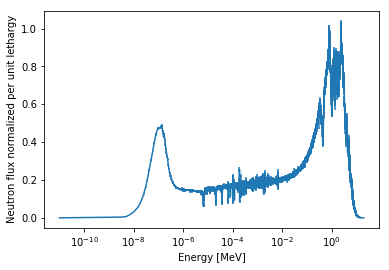

In [43]:
spectrum.spectrumPlot();

## Multi-dimensional Detectors

The `Detector` objects are capable of reshaping the detector data into an array where each axis corresponds to a varying bin. In the above examples, the reshaped data was one-dimensional, because the detectors only tallied data against one bin, universe and energy. In the following example, the detector has been configured to tally the fission and capture rates (two `dr` arguments) in an XY mesh.

In [44]:
xy = det.detectors['xyFissionCapt']
for key in xy.indexes:
    print(key, xy.indexes[key])

reaction [ 1.  2.]
ymesh [ 1.  2.  3.  4.  5.]
xmesh [ 1.  2.  3.  4.  5.]


Traversing the first axis in the `tallies` array corresponds to changing the value of the `reaction`. The second axis corresponds to changing `ymesh` values, and the final axis reflects changes in `xmesh`.

In [45]:
print(xy.bins.shape)
print(xy.tallies.shape)
print(xy.bins[:5, 10])
print(xy.tallies[0, 0, :5])

(50, 12)
(2, 5, 5)
[ 0.255119  0.255077  0.253685  0.255592  0.25845 ]
[ 0.255119  0.255077  0.253685  0.255592  0.25845 ]


### Slicing
As the detectors produced by SERPENT can contain multiple bin types, as seen in `DET_COLS`, obtaining data from the tally data can become complicated. This retrieval can be simplified using the `slice` method. This method takes an argument indicating what bins (keys in `indexes`) to fix at what position.

If we want to retrive the tally data for the XY mesh for the fission reactions

In [46]:
xy.slice({'reaction': 1})

array([[ 0.255119,  0.255077,  0.253685,  0.255592,  0.25845 ],
       [ 0.254101,  0.253408,  0.256666,  0.255375,  0.252936],
       [ 0.256006,  0.251002,  0.255479,  0.252002,  0.254708],
       [ 0.254957,  0.253399,  0.24818 ,  0.252915,  0.253914],
       [ 0.258394,  0.250217,  0.259642,  0.254025,  0.257076]])

As the fission reaction corresponded to reaction tally 1 in the original matrix.

This method also works for slicing the error, or score, matrix

In [47]:
xy.slice({'reaction': 2, 'ymesh': 4}, 'errors')

array([ 0.01576,  0.01299,  0.01811,  0.01367,  0.01632])

The method returned the relative error in the capture rate, along the fourth y-mesh,index 3 in the grid, for all x mesh points.

### Plotting
For data with dimensionality greater than one, the `meshPlot` method can be used to plot some 2D slice of the data.

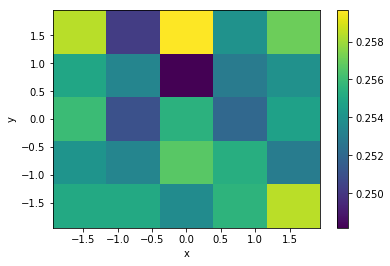

In [48]:
xy.meshPlot('x', 'y',fixed={'reaction':1});

The `meshPlot` also supports a range of labeling options

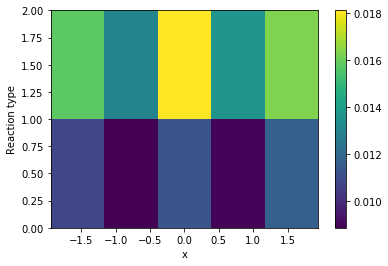

In [49]:
xy.meshPlot('x', 'reaction', what='errors',
            fixed={'ymesh': 4}, ylabel='Reaction type');

Using the `slicing` arguments allows access to the 1D plot methods from before

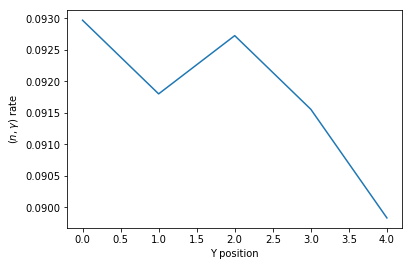

In [50]:
xy.plot(fixed={'reaction': 2, 'xmesh': 2}, 
        xlabel='Y position',
        ylabel=r'$\left(n,\gamma\right)$ rate');

## Conclusion

The `DetectorReader` is capable of reading and storing detector data from SERPENT detector files. The data is stored on custom `Detector` objects, capable of reshaping tally and error matrices into arrays with dimensionality reflecting the detector binning. These `Detector` objects have simple methods for retrieving and plotting detector data.

## References
1. J. Leppänen, M. Pusa, T. Viitanen, V. Valtavirta, and T. Kaltiaisenaho. "The Serpent Monte Carlo code: Status, development and applications in 2013." Ann. Nucl. Energy, [82 (2015) 142-150](https://www.sciencedirect.com/science/article/pii/S0306454914004095)